In [1]:
import os
import glob

from pathlib import Path
from itertools import groupby

from scheduler_runtime_stats import parse_scheduler_runtimes, parse_result, parse_slo

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [3]:
def scheduler_runtime_csv_files(dir="alibaba_scheduler_runtime-dsched"):
    for root, _, files in os.walk(dir):
        if root == dir:
            continue
        for file in files:
            if file.endswith(".csv"):
                yield os.path.join(root, file)

In [4]:
def parse_label(file):
    file = Path(file)
    sched = file.parts[-3]
    arrival_rate = sum(map(float, file.parts[-2].split("::")[1].split(":")))
    return sched, arrival_rate

In [5]:
def load_results(dir):
    results = []
    for file in scheduler_runtime_csv_files(dir):
        data = parse_result(file)
        sched, arrival_rate = parse_label(file)
        times = parse_scheduler_runtimes(data, file)
        slo = parse_slo(data)
        results.append(
            (sched, arrival_rate, slo, times)
        )
    return results

In [24]:
def boxplot(ax, results, title):

    for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
        result = sorted(result, key=lambda x: x[1])

        xs = [r[1] for r in result]
        ys = [r[3][200:-200] for r in result]
        boxplot = axs.boxplot(x=ys, sym='', label=group, patch_artist=True)
        for box in boxplot['boxes']:
            box.set(facecolor=sns.color_palette("pastel")[i])
        for median in boxplot['medians']:
            median.set(color='black', linewidth=1)
    
    ax.set_title(title)
    ax.set_xticks(range(1, len(xs)+1), [f'{x:.3f}' for x in xs], rotation=45)
    ax.set_xlabel('Arrival rate')
    ax.set_ylabel('Runtime (s)')
    ax.legend()

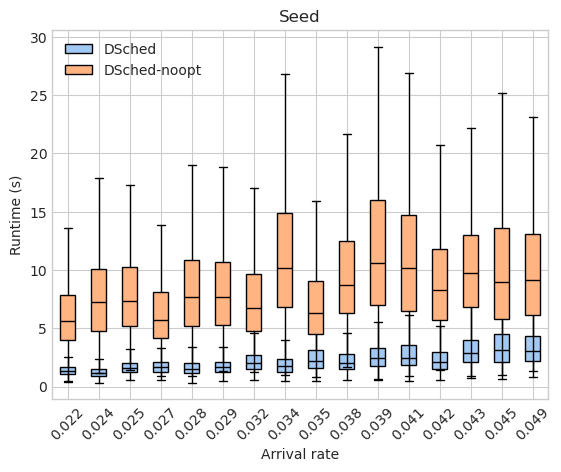

In [25]:
results = load_results("alibaba_scheduler_runtime-dsched")
fig, axs = plt.subplots()
boxplot(axs, results, "Seed")

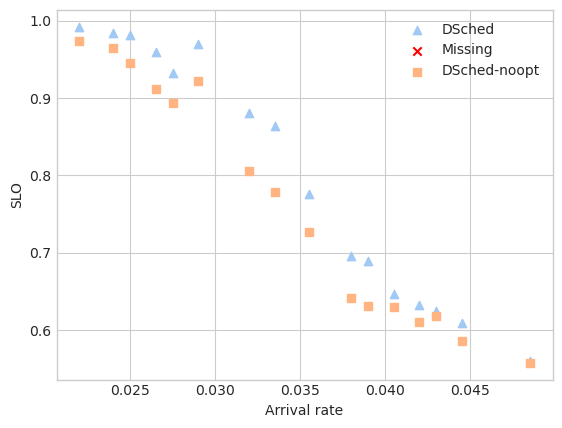

In [ ]:
markers = ['^', 's']
fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = np.array([r[1] for r in result])
    ys = np.array([r[2] for r in result], dtype=float)
    mask = ~np.isnan(ys)
    axs.scatter(xs[mask], ys[mask], label=group, marker=markers[i])

    nan_mask = np.isnan(ys)
    axs.scatter(xs[nan_mask], [0.50]*sum(nan_mask), marker='x', color='red', label='Missing')

plt.xlabel('Arrival rate')
plt.ylabel('SLO')

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # keeps last occurrence; use reversed(...) to keep first
plt.legend(unique.values(), unique.keys())
plt.show()

/tmp/ipykernel_3386552/3954942550.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


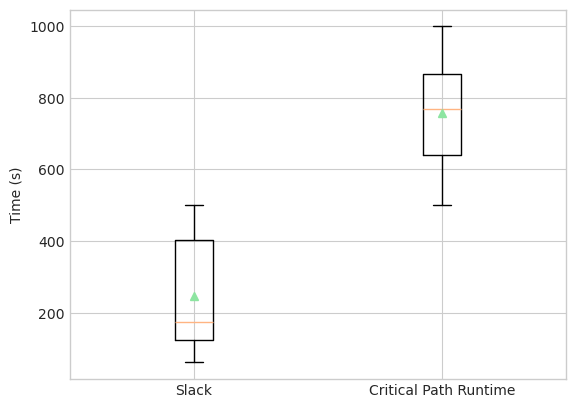

In [29]:
for file in scheduler_runtime_csv_files():
    data = parse_result(file)
    sched, arrival_rate = parse_label(file)

    slacks = []
    cprs = []
    for row in data:
        parts = row.split(",")
        if parts[1] == "TASK_GRAPH_RELEASE":
            release_time = float(parts[2])
            deadline = float(parts[3])
            critical_path_runtime = float(parts[-1])
            slack = deadline - (release_time + critical_path_runtime)

            slacks.append(slack)
            cprs.append(critical_path_runtime)

    fig, ax = plt.subplots()

    ax.boxplot([slacks, cprs], showmeans=True)
    ax.set_xticklabels(["Slack", "Critical Path Runtime"])
    ax.set_ylabel("Time (s)")
    plt.legend()
    plt.show()

    break

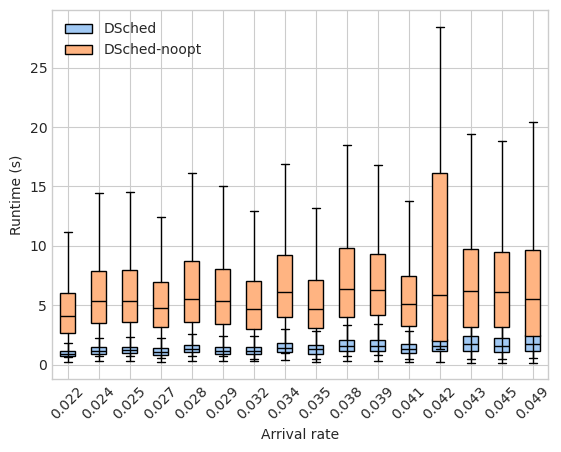

In [12]:
# Tighter deadlines

results = load_results("../alibaba_scheduler_runtime-dsched+tighter-deadlines")

fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = [r[1] for r in result]
    ys = [r[3] for r in result]
    boxplot = axs.boxplot(x=ys, sym='', label=group, patch_artist=True)
    for box in boxplot['boxes']:
        box.set(facecolor=sns.color_palette("pastel")[i])
    for median in boxplot['medians']:
        median.set(color='black', linewidth=1)

plt.xticks(range(1, len(xs)+1), [f'{x:.3f}' for x in xs], rotation=45)
plt.xlabel('Arrival rate')
plt.ylabel('Runtime (s)')

plt.legend()
plt.show()

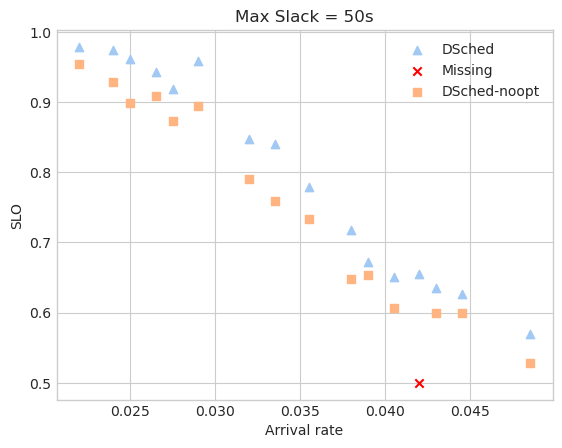

In [15]:
markers = ['^', 's']
fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = np.array([r[1] for r in result])
    ys = np.array([r[2] for r in result], dtype=float)
    mask = ~np.isnan(ys)
    axs.scatter(xs[mask], ys[mask], label=group, marker=markers[i])

    nan_mask = np.isnan(ys)
    axs.scatter(xs[nan_mask], [0.50]*sum(nan_mask), marker='x', color='red', label='Missing')

plt.xlabel('Arrival rate')
plt.ylabel('SLO')
plt.title("Max Slack = 50s")

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # keeps last occurrence; use reversed(...) to keep first
plt.legend(unique.values(), unique.keys())
plt.show()

/tmp/ipykernel_3603281/3052203244.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


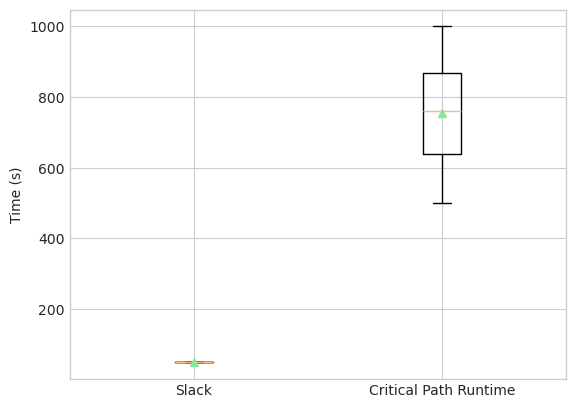

In [14]:
for file in scheduler_runtime_csv_files("../alibaba_scheduler_runtime-dsched+tighter-deadlines"):
    data = parse_result(file)
    sched, arrival_rate = parse_label(file)

    slacks = []
    cprs = []
    for row in data:
        parts = row.split(",")
        if parts[1] == "TASK_GRAPH_RELEASE":
            release_time = float(parts[2])
            deadline = float(parts[3])
            critical_path_runtime = float(parts[-1])
            slack = deadline - (release_time + critical_path_runtime)

            slacks.append(slack)
            cprs.append(critical_path_runtime)

    fig, ax = plt.subplots()

    ax.boxplot([slacks, cprs], showmeans=True)
    ax.set_xticklabels(["Slack", "Critical Path Runtime"])
    ax.set_ylabel("Time (s)")
    plt.legend()
    plt.show()

    break

In [20]:
results = []
for file in scheduler_runtime_csv_files("../alibaba_scheduler_runtime-dsched+tighter-deadlines"):
    data = parse_result(file)
    sched, arrival_rate = parse_label(file)

    m = 0
    for row in data:
        parts = row.split(",")
        if parts[1] == "SCHEDULER_START":
            st = int(parts[2])
            if st > m:
                m = st

    results.append((sched, arrival_rate, m))

results = sorted(results, key=lambda x: (x[0], x[1]))

for result in results:
    sched, arrival_rate, m = result
    print(sched, f"{arrival_rate:.3f}", "\t", m)



DSched 0.022 	 144
DSched 0.024 	 167
DSched 0.025 	 155
DSched 0.027 	 174
DSched 0.028 	 213
DSched 0.029 	 175
DSched 0.032 	 197
DSched 0.034 	 205
DSched 0.035 	 216
DSched 0.038 	 261
DSched 0.039 	 231
DSched 0.041 	 229
DSched 0.042 	 250
DSched 0.043 	 275
DSched 0.045 	 289
DSched 0.049 	 294
DSched-noopt 0.022 	 169
DSched-noopt 0.024 	 174
DSched-noopt 0.025 	 182
DSched-noopt 0.027 	 188
DSched-noopt 0.028 	 200
DSched-noopt 0.029 	 192
DSched-noopt 0.032 	 231
DSched-noopt 0.034 	 224
DSched-noopt 0.035 	 239
DSched-noopt 0.038 	 252
DSched-noopt 0.039 	 223
DSched-noopt 0.041 	 242
DSched-noopt 0.042 	 142
DSched-noopt 0.043 	 291
DSched-noopt 0.045 	 264
DSched-noopt 0.049 	 277


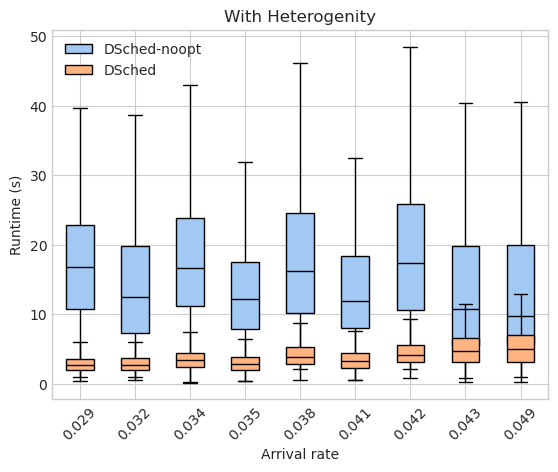

In [8]:
results = load_results("../alibaba_scheduler_runtime-dsched+hetero")

fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = [r[1] for r in result]
    ys = [r[3] for r in result]
    boxplot = axs.boxplot(x=ys, sym='', label=group, patch_artist=True)
    for box in boxplot['boxes']:
        box.set(facecolor=sns.color_palette("pastel")[i])
    for median in boxplot['medians']:
        median.set(color='black', linewidth=1)

plt.xticks(range(1, len(xs)+1), [f'{x:.3f}' for x in xs], rotation=45)
plt.xlabel('Arrival rate')
plt.ylabel('Runtime (s)')
plt.title("With Heterogenity")

plt.legend()
plt.show()

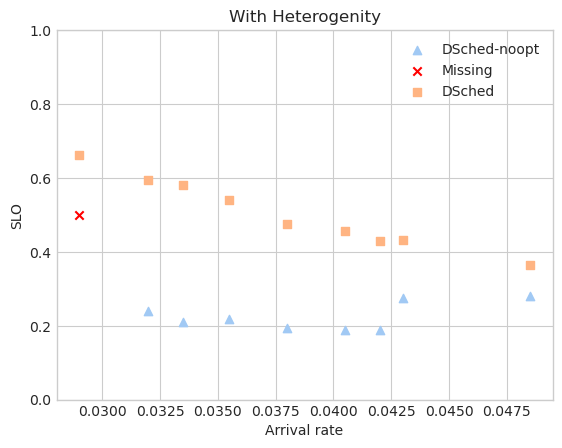

In [11]:
markers = ['^', 's']
fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = np.array([r[1] for r in result])
    ys = np.array([r[2] for r in result], dtype=float)
    mask = ~np.isnan(ys)
    axs.scatter(xs[mask], ys[mask], label=group, marker=markers[i])

    nan_mask = np.isnan(ys)
    axs.scatter(xs[nan_mask], [0.50]*sum(nan_mask), marker='x', color='red', label='Missing')
axs.set_ylim(0, 1)

plt.xlabel('Arrival rate')
plt.ylabel('SLO')
plt.title("With Heterogenity")

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # keeps last occurrence; use reversed(...) to keep first
plt.legend(unique.values(), unique.keys())
plt.show()